Задание1:

Реализовать архитектуру подобную ResNet18 для датасета CIFAR10. Под реализацией подразумевается собственная реализация res-блока и архитектуры классификатора. Обязательно построить learning curve для трейна и теста. Топовые модели дают accuracy >95%. Приемлемая accuracy >90%.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# hyperparams
inp_dim = 32 * 32 * 3
hidden = 256
out_dim = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_epochs = 50
batch_size = 100
torch.manual_seed(22)

# plot settings
sns.set_style("dark")

In [ ]:
transform_train = transforms.Compose(
    [transforms.TrivialAugmentWide(interpolation=transforms.InterpolationMode.BILINEAR),
     transforms.ToTensor(),
     transforms.RandomHorizontalFlip(),
     transforms.RandomAffine(15, scale=(0.9, 1.1)),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
     #transforms.RandomAutocontrast(),
     #transforms.RandomGrayscale(),
     ])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
     ])


dataset_train = datasets.CIFAR10('.', 
                               train=True,            
                               download=True, 
                               transform=transform_train)
trainloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

dataset_test = datasets.CIFAR10('.', 
                              train=False,
                              download=True, 
                              transform=transform_test)
testloader = torch.utils.data.DataLoader(dataset_test, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)


Files already downloaded and verified
Files already downloaded and verified


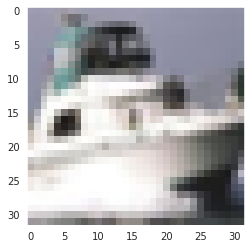

ship


In [ ]:
plt.imshow(dataset_train.data[4001])
plt.show()
print(dataset_train.classes[dataset_train.targets[4001]])

In [ ]:
import torch.nn as nn
import math


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, layers, num_classes=10, input_channels=3):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, layers[0])
        self.layer2 = self._make_layer(128, layers[1], stride=2)
        self.layer3 = self._make_layer(256, layers[2], stride=2)
        self.layer4 = self._make_layer(512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d((1, 1))

        self.dropout = nn.Dropout2d(p=0.5,inplace=True)

        self.fc = nn.Linear(512, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = []
        layers.append(BasicBlock(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(BasicBlock(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

resnet_18 = lambda: ResNet([2, 2, 2, 2])
resnet_34 = lambda: ResNet([3, 4, 6, 3])

In [ ]:
def accuracy(true, pred):
    return torch.sum(true == pred) / pred.size(0)

epoch: 50, loss: 0.905, accuracy: 0.685


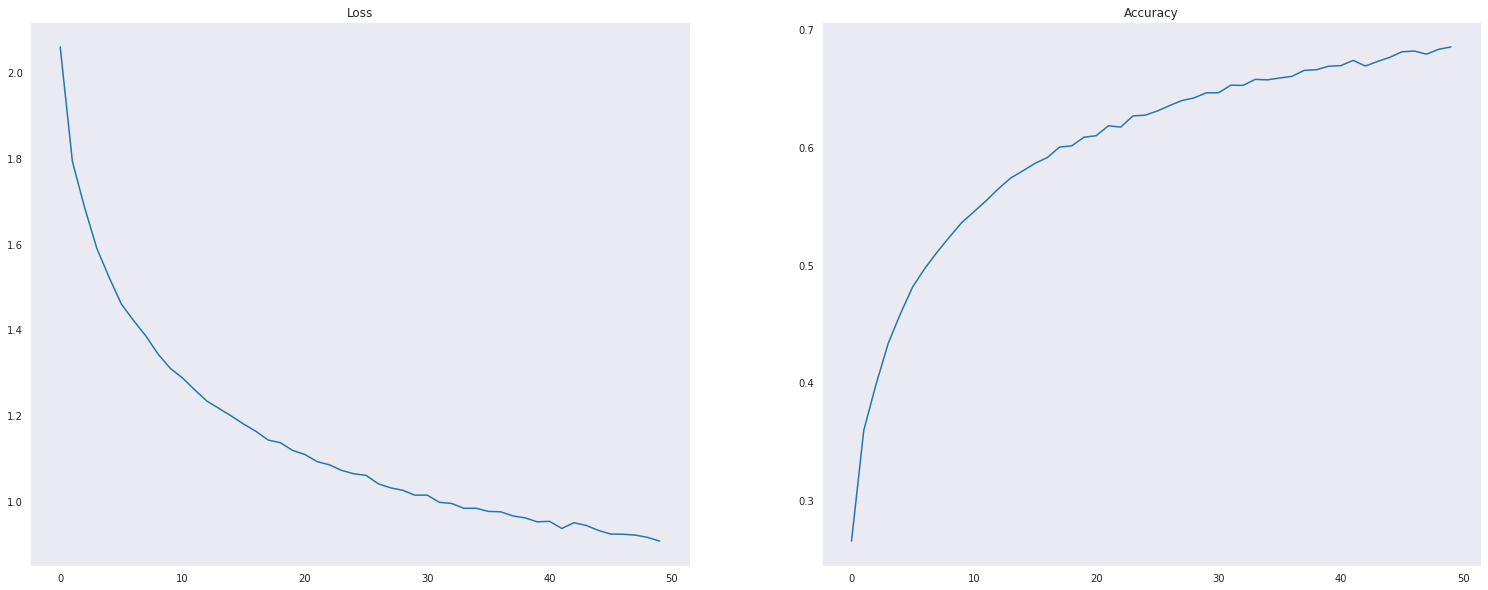

In [ ]:
from IPython import display

model = resnet_18().to(device)
model.train()
#optim = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)
loss_func = nn.CrossEntropyLoss()
#lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=3, verbose=True)
optim = torch.optim.SGD(model.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optim, base_lr=0.005, max_lr=0.2)

losses = []
accs = []
best_acc = 0
for epoch in range(1, n_epochs+1):
    epoch_accs = []
    epoch_losses = []
    for i, (data, targets) in enumerate(trainloader):
        optim.zero_grad()
        predict = model(data.to(device))
        loss = loss_func(predict, targets.to(device))
        loss.backward()
        optim.step()

        loss = loss.item()
        epoch_losses.append(loss)
        acc = accuracy(targets, torch.max(predict,1)[1].cpu())
        epoch_accs.append(acc.cpu())
        if i % 30 == 0:
            print(f"\rstep: {i} loss: {loss:.3f}, acc: {acc:.3f}", end="")

    epoch_acc = np.mean(epoch_accs)
    epoch_loss = np.mean(epoch_losses)
    lr_scheduler.step(epoch)

    #display
    display.clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(26,10))
    ax1.set_title("Loss")
    ax2.set_title("Accuracy")
    accs.append(epoch_acc)
    losses.append(epoch_loss)
    sns.lineplot(x=range(0, len(losses)), y=losses, ax=ax1, )
    sns.lineplot(x=range(0, len(accs)),y=accs, ax=ax2)
    print(f'epoch: {epoch}, loss: {epoch_loss:.3f}, accuracy: {epoch_acc:.3f}')
    display.display(fig)
    plt.close(fig)
    #save every epoch
    torch.save(model.state_dict(), f'./chkpt_cv1_{epoch}.pth')
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), f'./best_acc.pth')

In [ ]:
model = resnet_18().to(device)
model.load_state_dict(torch.load('./best_acc.pth'))
model.eval()

batches_acc = []
for i, (data, targets) in enumerate(testloader):
    predict = model(data.to(device))
    _, predict = torch.max(predict, 1)
    predict = predict.to("cpu")
    batches_acc.append(torch.sum(predict == targets) / targets.size(0))
np.mean(batches_acc)

0.7982